In [133]:
import osmnx
from pyproj import Geod
import geopandas as gpd
from math import ceil, floor
from shapely.geometry import Point, box
from rasterio.features import rasterize
import rasterio
import numpy as np

def BB_to_tile_coords(bb_coords, m_p_p = 2, reso = [500,500], Plot_remainder = False, single_tile = False,verbose = False, ):
    width_m, height_m = BB_dimensions(bb_coords, verbose) #land dimensions of bounding box in meters

    tile_dim =  [x * m_p_p for x in reso] # land area of individual tiles in meters
    print("Tile Dimensions:", f"{tile_dim[0]}m x {tile_dim[1]}m @ {reso[0]}px x {reso[1]}px" ) if verbose else None

    #calculate number of tiles needed
    num_tiles_x = ceil(width_m / tile_dim[0]) if Plot_remainder else floor(width_m / tile_dim[0])
    num_tiles_y = ceil(height_m / tile_dim[1]) if Plot_remainder else floor(height_m / tile_dim[1])
    print("Number of Tiles Needed:", f"{num_tiles_x} (X) x {num_tiles_y} (Y) = {num_tiles_x * num_tiles_y} Total") if verbose else None

    #generate tile coordinates based on tile_dim and number of tiles

    return get_tile_coordinates(bb_coords, tile_dim, num_tiles_x, num_tiles_y, single_tile, verbose)
    
def BB_dimensions(bb_coords, verbose = False):
    print("(BB_dimensions)") if verbose else None
    g = Geod(ellps='WGS84')
    minx, miny, maxx, maxy = map(float, bb_coords.split(','))
    _, _, width_m = g.inv(minx, miny, maxx, miny)
    _, _, height_m = g.inv(minx, miny, minx, maxy)
    print("Bounding Box Width (m):", width_m, "| Height (m):", height_m) if verbose else None
    return width_m, height_m

def get_tile_coordinates(bb_coords, tile_dim, num_tiles_x, num_tiles_y, single_tile = False, verbose = False):
    """Starting with bottom left. Generate tile coordinates given bounding box, tile dimensions, and number of tiles. """
    print("(get_tile_coordinates)") if verbose else None
    minx, miny, maxx, maxy = map(float, bb_coords.split(','))
    g = Geod(ellps='WGS84')
    tiles = []

    tile_width_m, tile_height_m = tile_dim
    print(tile_width_m, tile_height_m) if verbose else None
    # generate 4 corner coordinates for each tile
    if single_tile:
        num_tiles_x, num_tiles_y = 1, 1
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            # Pointer(lon_w, lat_s), starting from Home(minx, miny), this is the bottom left corner of the tile
            lon_w, lat_s, _ = g.fwd(minx, miny, az=90, dist=i*tile_width_m) 
            #bottom right corner of tile coordinate
            lon_e, _ , _ = g.fwd(lon_w, lat_s, az=90, dist=tile_width_m)
            # Shift north for y direction
            _, lat_n, _ = g.fwd(lon_w, lat_s, az=0, dist=tile_height_m)
            
            # Bounding box of tile
            tile_bbox = (lon_w, lat_s, lon_e, lat_n)  # (min_lon, min_lat, max_lon, max_lat)
            tiles.append(tile_bbox)
    if verbose:
        print(len(tiles), "tiles generated.") 
        for tile in tiles:
            print("Tile Coordinates:", tile)
    return tiles

def generate_tile_tensor(coords, m_p_p, reso, building_tags, water_tags, green_tags, verbose = False):
    print("(generate_tile_tensor)") if verbose else None
    w, s, e, n = coords
    #create bounding box polygon in WGS84 coordinates(in degrees)
    bbox_wgs = gpd.GeoSeries(
        [box(w, s, e, n)],
        crs="EPSG:4326"
        )
    print("Tile Polygon (EPSG:4326):", bbox_wgs) if verbose else None
    
    # Convert to EPSG:3857 for rasterizing(in meters)
    bbox_poly = bbox_wgs.to_crs(3857)
    xmin, ymin, xmax, ymax = bbox_poly.total_bounds
    print("Tile Polygon (EPSG:3857):", bbox_poly) if verbose else None

    #transform using 
    transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, reso[0], reso[1]) 
    print("Raster Transform:", transform) if verbose else None
    has_buildings, has_water, has_greenery = True, True, True

    try:
        buildings = osmnx.features_from_bbox((w,s,e,n), tags=building_tags)
        buildings = buildings.to_crs(epsg=3857)   
    except:
        has_buildings = False
        buildings = gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")

    try:
        water = osmnx.features_from_bbox((w,s,e,n), tags=water_tags)
        water = water.to_crs(epsg=3857)   
    except:
        has_water = False
        water = gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")

    try:
        greenery = osmnx.features_from_bbox((w,s,e,n), tags=green_tags)
        greenery = greenery.to_crs(epsg=3857)   
    except:
        has_greenery = False
        greenery = gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")

    return buildings, water, greenery






def generate_tile_geodf(tile_coords, tags_dict):
    w,s,e,n = tile_coords
    layers = {}
    for name, tags in tags_dict.items():
        try:
            gdf = osmnx.features_from_bbox((w, s, e, n), tags=tags)
            gdf = gdf.to_crs(epsg=3857)
            layers[name] = gdf
        except Exception:
            layers[name] = gpd.GeoDataFrame(geometry=[], crs="EPSG:3857")
    return layers


import matplotlib.pyplot as plt
def plot_image(geodf):
    plt.imshow(geodf)
    return

def rasterize_layer(gdf, reso, transform):
    if gdf.empty:

        return np.zeros(reso, dtype=np.uint8)
    shapes = [(geom, 1) for geom in gdf.geometry]
    return rasterize(shapes,
                      out_shape=reso,
                      transform=transform,
                      fill=0, dtype=np.uint8)


(BB_dimensions)
Bounding Box Width (m): 1706.0133013826849 | Height (m): 1029.452823483809
Tile Dimensions: 125.0m x 250.0m @ 250px x 500px
Number of Tiles Needed: 13 (X) x 4 (Y) = 52 Total
(get_tile_coordinates)
125.0 250.0
1 tiles generated.
Tile Coordinates: (103.89813, 1.4116899999999997, 103.89925323274294, 1.4139509098910765)
(generate_tile_tensor)
Tile Polygon (EPSG:4326): 0    POLYGON ((103.89925 1.41169, 103.89925 1.41395...
dtype: geometry
Tile Polygon (EPSG:3857): 0    POLYGON ((11566011.964 157164.514, 11566011.96...
dtype: geometry
Raster Transform: | 0.50, 0.00, 11565886.93|
| 0.00,-0.50, 157416.27|
| 0.00, 0.00, 1.00|


TypeError: Image data of dtype object cannot be converted to float

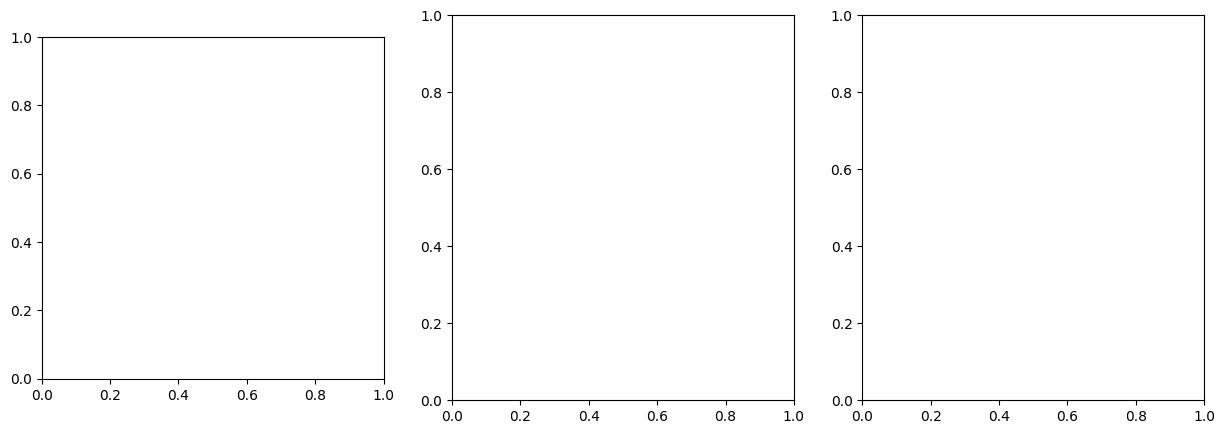

In [134]:
bb_coords = "103.89813,1.41169,103.91346,1.42100"
m_p_p = .5
reso = [250,500]

tiles_list = BB_to_tile_coords(bb_coords, m_p_p = m_p_p, reso = reso, Plot_remainder=False, verbose=True, single_tile=True)

building_tags = {
      "building": True,
      "man_made": ["pier"]}
water_tags = {
      "natural": [
          "water", "bay", "strait", "spring", "waterfall",
          "wetland", "glacier", "reef", "shoal"
      ],
      "waterway": [
          "river", "riverbank", "canal", "stream", "ditch",
          "drain", "weir", "lock_gate", "rapids", "tidal_channel"
      ],
      "landuse": [
          "reservoir", "basin", "harbour", "quay",
          "salt_pond", "fishpond", "aquaculture"
      ],
      "man_made": [
          "dock", "water_well", "water_tower",
          "wastewater_plant", "clarifier", "reservoir_covered"
      ]
  }
green_tags = {
    "natural": ["wood", "scrub", "grassland", "heath", "moor", "fell", "wetland"],
    "landuse": ["forest", "meadow", "grass", "village_green", "recreation_ground", "allotments"],
    "leisure": ["park", "garden", "nature_reserve", "golf_course", "pitch", "playground"]
  }


for tile in tiles_list:
    tensor = generate_tile_tensor(tile, m_p_p, reso, building_tags, water_tags, green_tags, verbose=True)
    # plot_image(tensor)
    layer_names = ["Buildings", "water", "Greens"]  # optional names
    tensor
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        ax = axes[i]
        ax.imshow(tensor[i], cmap="viridis")   # you can use different colormaps if you like
        ax.set_title(layer_names[i])
        ax.axis("off")

plt.tight_layout()
plt.show()





In [135]:
bb_coords = "103.89813,1.41169,103.91346,1.42100"
m_p_p = .5
reso = [250,500]

tiles_list = BB_to_tile_coords(bb_coords, m_p_p, reso, Plot_remainder=False, verbose=True, single_tile=True)

building_tags = {
      "building": True,
      "man_made": ["pier"]}
water_tags = {
      "natural": [
          "water", "bay", "strait", "spring", "waterfall",
          "wetland", "glacier", "reef", "shoal"
      ],
      "waterway": [
          "river", "riverbank", "canal", "stream", "ditch",
          "drain", "weir", "lock_gate", "rapids", "tidal_channel"
      ],
      "landuse": [
          "reservoir", "basin", "harbour", "quay",
          "salt_pond", "fishpond", "aquaculture"
      ],
      "man_made": [
          "dock", "water_well", "water_tower",
          "wastewater_plant", "clarifier", "reservoir_covered"
      ]
  }
green_tags = {
    "natural": ["wood", "scrub", "grassland", "heath", "moor", "fell", "wetland"],
    "landuse": ["forest", "meadow", "grass", "village_green", "recreation_ground", "allotments"],
    "leisure": ["park", "garden", "nature_reserve", "golf_course", "pitch", "playground"]
  }
tags_dict = {
    "buildings": building_tags,
    "water": water_tags,
    "greenery": green_tags
}

layers_list = []
for tile in tiles_list:
    layers_list.append(generate_tile_geodf(tile, tags_dict))
    

(BB_dimensions)
Bounding Box Width (m): 1706.0133013826849 | Height (m): 1029.452823483809
Tile Dimensions: 125.0m x 250.0m @ 250px x 500px
Number of Tiles Needed: 13 (X) x 4 (Y) = 52 Total
(get_tile_coordinates)
125.0 250.0
1 tiles generated.
Tile Coordinates: (103.89813, 1.4116899999999997, 103.89925323274294, 1.4139509098910765)


In [136]:
print(layers_list)

[{'buildings':                                                              geometry  \
element  id                                                             
relation 7785508    POLYGON ((11566008.843 157215.135, 11566009.07...   
way      397582713  POLYGON ((11565878.321 157256.058, 11565880.69...   
         397582717  POLYGON ((11565909.502 157309.53, 11565902.934...   
         397582718  POLYGON ((11565913.353 157338.426, 11565929.61...   
         397582719  POLYGON ((11565919.442 157376.186, 11565913.26...   
         397582720  POLYGON ((11565870.462 157326.634, 11565880.88...   
         397582721  POLYGON ((11565925.008 157357.189, 11565930.66...   
         397583418  POLYGON ((11566004.401 157323.07, 11566000.539...   
         397583430  POLYGON ((11565990.665 157361.498, 11565986.61...   
         397583432  POLYGON ((11566005.915 157265.2, 11566012.906 ...   

                    addr:city addr:country addr:housenumber  \
element  id                                  